In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

df = pd.read_csv("C:/Users/Kofidence/Desktop/wfp_food_prices_uga.csv")

In [4]:
df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2006-01-15,Busia,Samia-bugwe,Busia,0.467,34.09,cereals and tubers,Maize,KG,actual,Wholesale,UGX,298.4,0.1641
2,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,UGX,345.42,0.19
3,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,UGX,1013.4,0.5573
4,2006-01-15,Lira,Lira Municipality,Lira,2.235,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,UGX,247.76,0.1362


In [5]:
# dropping a range of rows containing forecast price(0.0); from it's start to it's end
df = df.drop(df.index[15417:16505])

#dropping the first row
df = df.drop(0)

#dropping the columns which are not required
df = df.drop(['admin1', 'admin2','unit', 'priceflag', 'currency', 'usdprice'], axis=1)

In [6]:
# dividing the dataset into two; wholesale price only and retail price only
wholesale_df = df[df['pricetype']=='Wholesale'].reset_index(drop=True)
retail_df = df[df['pricetype']=='Retail'].reset_index(drop=True)

#deleting the the pricetype column
del retail_df["pricetype"]

In [7]:
#obtaining the dataset for maize in Owino market
cereal_tuber_retail_df= retail_df[retail_df['category']== 'cereals and tubers'].reset_index(drop=True)
cereal_tuber_retail_df= retail_df[retail_df['market']== 'Owino'].reset_index(drop=True)
cereal_tuber_retail_df = cereal_tuber_retail_df[cereal_tuber_retail_df["commodity"] == "Maize flour"].reset_index(drop=True)

#dropping redundant columns
cereal_tuber_retail_df = cereal_tuber_retail_df.drop(['category', 'market', 'latitude', 'longitude','commodity'], axis=1)

# converting columns price from data type object to float
cereal_tuber_retail_df['price'] = cereal_tuber_retail_df['price'].astype(float)

In [8]:
#setting the date as the index column
cereal_tuber_retail_df = cereal_tuber_retail_df.set_index('date')

#converting the date to datetime
cereal_tuber_retail_df.index=pd.to_datetime(cereal_tuber_retail_df.index)

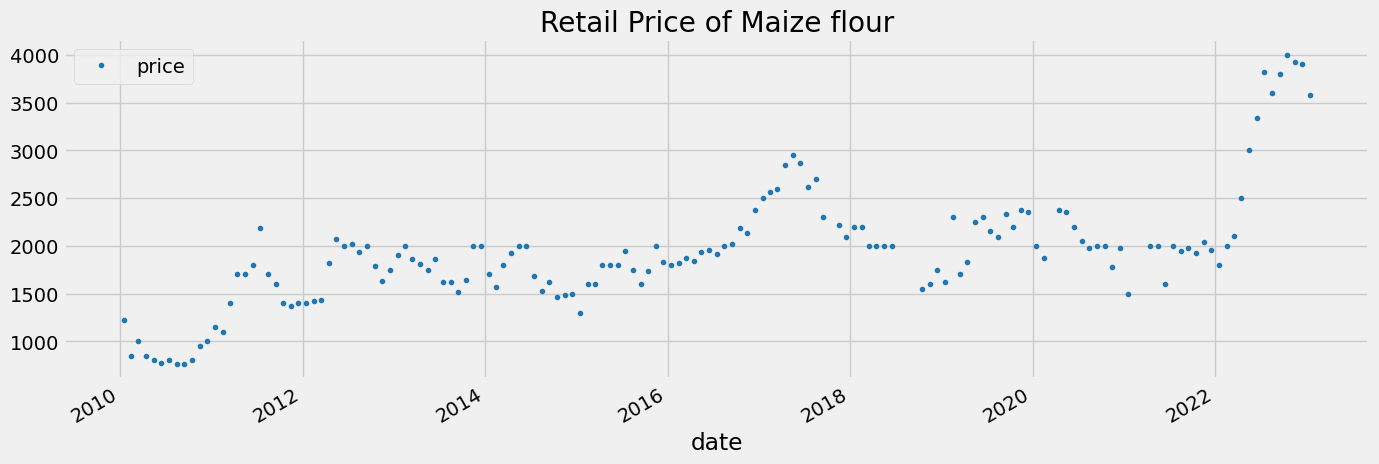

In [9]:
#Data visualisation
cereal_tuber_retail_df.plot(style='.',
                           figsize=(15, 5),
                           color=color_pal[0],
                           title='Retail Price of Maize flour')
plt.show()

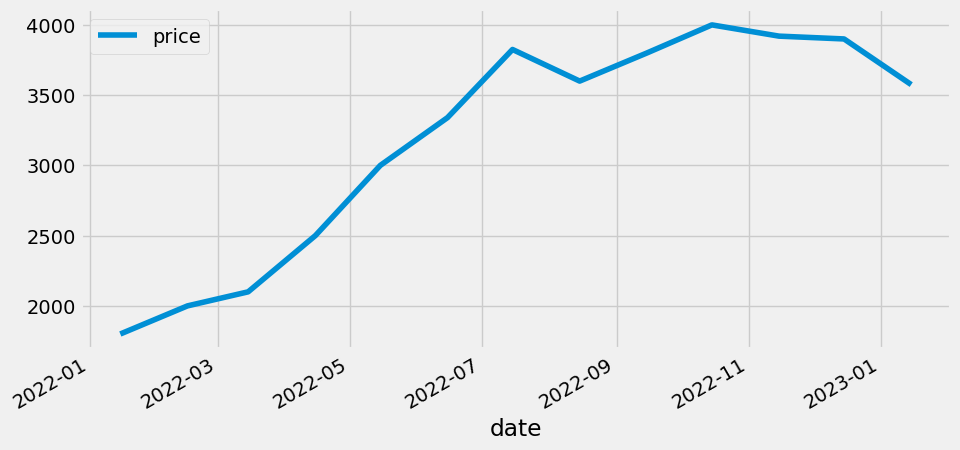

In [10]:
#monthly price distribution
filtered_df = cereal_tuber_retail_df.loc[
    (cereal_tuber_retail_df.index >= '2022-01-15') &
    (cereal_tuber_retail_df.index <= '2023-01-15')
]

filtered_df.plot(figsize=(10, 5))
plt.show()

ValueError: Could not interpret input 'month'

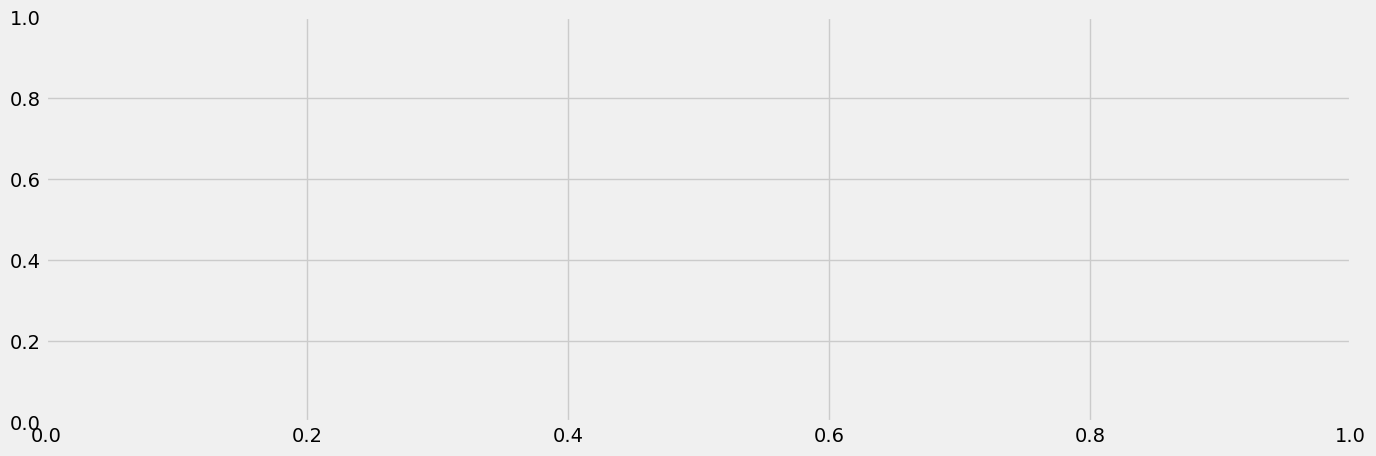

In [11]:
#monthly boxplot for monthly price for MAize flour
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=cereal_tuber_retail_df, x='month', y='price')
ax.set_title('monthly Retail Price of Maize flour')

plt.show()

In [12]:
#splitting the dataset into training and test sets
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=30)
cereal_tuber_retail_df = cereal_tuber_retail_df.sort_index()

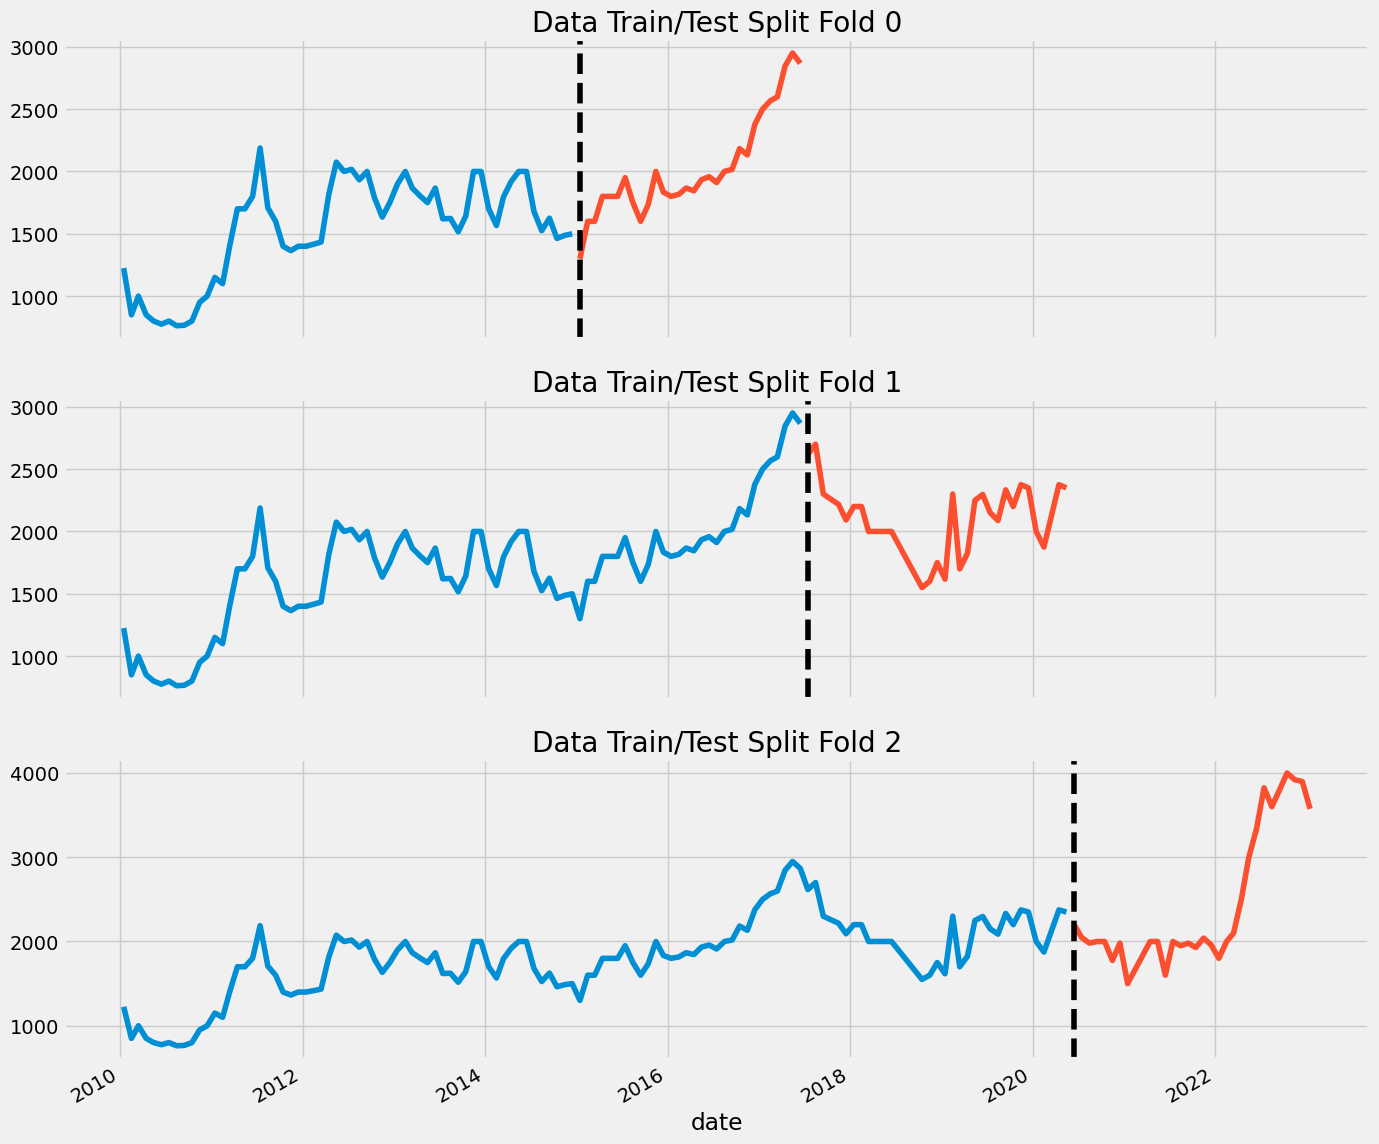

In [13]:
#Visualising the splitting
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(cereal_tuber_retail_df):
    train = cereal_tuber_retail_df.iloc[train_idx]
    test = cereal_tuber_retail_df.iloc[val_idx]
    train['price'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['price'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [14]:
#feature creation
def feature_creation(cereal_tuber_retail_df):
    cereal_tuber_retail_df = cereal_tuber_retail_df.copy()
    cereal_tuber_retail_df["dayofweek"] = cereal_tuber_retail_df.index.dayofweek
    cereal_tuber_retail_df["quarter"] = cereal_tuber_retail_df.index.quarter
    cereal_tuber_retail_df["month"] = cereal_tuber_retail_df.index.month
    cereal_tuber_retail_df["year"] = cereal_tuber_retail_df.index.year
    cereal_tuber_retail_df["dayofyear"] = cereal_tuber_retail_df.index.dayofyear
    cereal_tuber_retail_df["dayofmonth"] = cereal_tuber_retail_df.index.day
    cereal_tuber_retail_df["weekofyear"] = cereal_tuber_retail_df.index.isocalendar().week
    
    return cereal_tuber_retail_df

cereal_tuber_retail_df = feature_creation(cereal_tuber_retail_df)

#Creation of lag features

def add_lags(cereal_tuber_retail_df):
    target_map = cereal_tuber_retail_df['price'].to_dict()
    cereal_tuber_retail_df['lag1'] = (cereal_tuber_retail_df.index - pd.Timedelta('365 days')).map(target_map)
    cereal_tuber_retail_df['lag2'] = (cereal_tuber_retail_df.index - pd.Timedelta('730 days')).map(target_map)
    
    return cereal_tuber_retail_df

cereal_tuber_retail_df = add_lags(cereal_tuber_retail_df)

In [15]:
#training using cross volidation
tss = TimeSeriesSplit(n_splits=3, test_size=30)
cereal_tuber_retail_df = cereal_tuber_retail_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(cereal_tuber_retail_df):
    train = cereal_tuber_retail_df.iloc[train_idx]
    test = cereal_tuber_retail_df.iloc[val_idx]

    train = feature_creation(train)
    test = feature_creation(test)

    FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'dayofmonth','year',
                'lag1','lag2']
    TARGET = 'price'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[16:28:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1572.13038	validation_1-rmse:2053.75362
[100]	validation_0-rmse:624.03333	validation_1-rmse:1028.63604
[200]	validation_0-rmse:281.43439	validation_1-rmse:668.34288
[300]	validation_0-rmse:154.62221	validation_1-rmse:551.66729
[400]	validation_0-rmse:105.04054	validation_1-rmse:508.49245
[500]	validation_0-rmse:85.45281	validation_1-rmse:494.59862
[600]	validation_0-rmse:74.58823	validation_1-rmse:491.02506
[700]	validation_0-rmse:67.84740	validation_1-rmse:489.02508
[800]	validation_0-rmse:62.06207	validation_1-rmse:486.24027
[900]	validation_0-rmse:58.08218	validation_1-rmse:485.15025
[999]	validation_0-rmse:53.95406	validation_1-rmse:485.22568
[16:28:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0759

In [16]:
#Retraining all the data
cereal_tuber_retail_df = feature_creation(cereal_tuber_retail_df)

FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'dayofmonth','year',
                'lag1','lag2']

TARGET = 'price'

X_all = cereal_tuber_retail_df[FEATURES]
y_all = cereal_tuber_retail_df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_all, y_all,
       eval_set=[(X_all, y_all)],
       verbose = 100)

[16:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2012.73554
[100]	validation_0-rmse:804.52348
[200]	validation_0-rmse:367.81506
[300]	validation_0-rmse:224.07208
[400]	validation_0-rmse:174.60580
[499]	validation_0-rmse:152.23754


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [17]:
#determing the latest dataset
cereal_tuber_retail_df.index.max()

Timestamp('2023-01-15 00:00:00')

In [18]:
#feature creation for monthly prediction
future = pd.date_range('2023-01-15', '2024-01-15', freq='M')
future = future + pd.DateOffset(days=15)
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
cereal_tuber_retail_df['isFuture'] = False
future_retail = pd.concat([cereal_tuber_retail_df, future_df])
future_retail = feature_creation(future_retail)
future_retail = add_lags(future_retail)

Monthly_future = future_retail.query('isFuture').copy()

In [19]:
#Future prediction
Monthly_future['preds'] = reg.predict(Monthly_future[FEATURES])

In [20]:
#Predicted result
Monthly_future

,price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture,preds
2023-02-15,NaN,2,1,2,2023,46,15,7,2000.0,NaN,True,2427.667725
2023-03-15,NaN,2,1,3,2023,74,15,11,2100.0,NaN,True,2405.266846
2023-04-15,NaN,5,2,4,2023,105,15,15,2500.0,2000.0,True,3492.324219
2023-05-15,NaN,0,2,5,2023,135,15,20,3000.0,2000.0,True,3472.462402
2023-06-15,NaN,3,2,6,2023,166,15,24,3340.0,1600.0,True,3482.425537
2023-07-15,NaN,5,3,7,2023,196,15,28,3825.0,2000.0,True,3656.516357
2023-08-15,NaN,1,3,8,2023,227,15,33,3600.0,1950.0,True,3634.287109
2023-09-15,NaN,4,3,9,2023,258,15,37,3800.0,1980.0,True,3656.491211
2023-10-15,NaN,6,4,10,2023,288,15,41,4000.0,1929.0,True,3612.278320
2023-11-15,NaN,2,4,11,2023,319,15,46,3920.0,2040.0,True,3612.278320


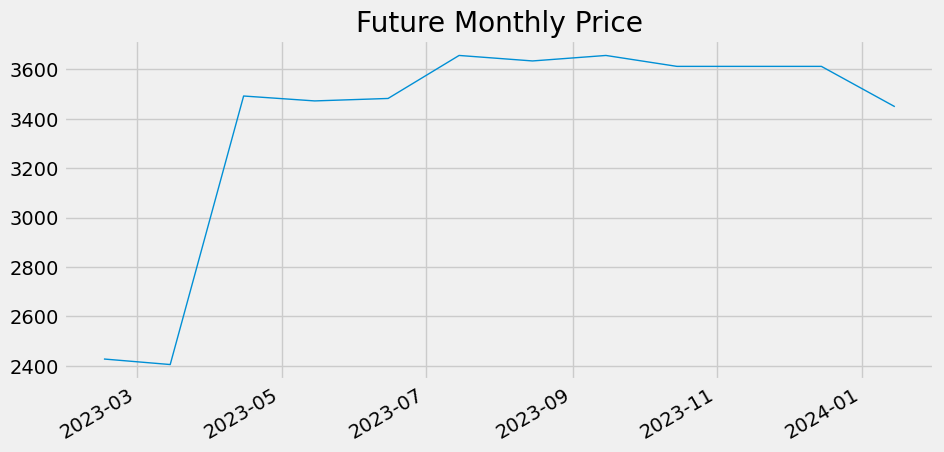

In [21]:
#result visualisation

Monthly_future['preds'].plot(figsize=(10, 5),
                            ms=1,
                            lw=1,
                            title='Future Monthly Price')

plt.show()

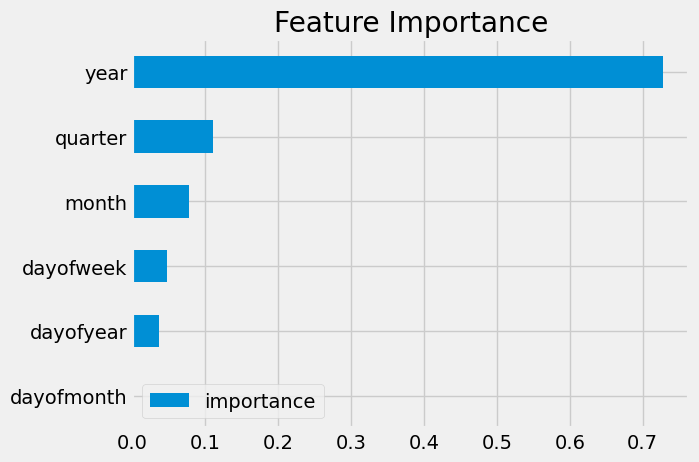

In [60]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [1]:
fi = pd.DataFrame(data=reg.feature_importances_,
              index=reg.feature_names_in_,
            columns=['importance'])

NameError: name 'pd' is not defined

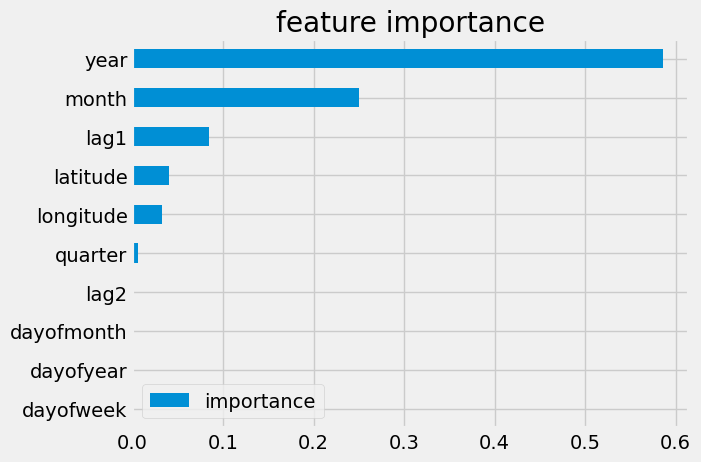

In [116]:
fi.sort_values('importance').plot(kind='barh', title='feature importance')
plt.show()

In [117]:
print(f'Scores across folds {np.mean(scores):0.4f}')

print(f'Fold scores: {scores}')

Scores across folds 1415.7129
Fold scores: [857.6571780637672, 1806.3887632753956, 1583.0926260466615]
